In [176]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [177]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

In [178]:
df = pd.read_csv('/kaggle/input/who-is-the-real-winner/train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2059 non-null   int64 
 1   Candidate       2059 non-null   object
 2   Constituency ∇  2059 non-null   object
 3   Party           2059 non-null   object
 4   Criminal Case   2059 non-null   int64 
 5   Total Assets    2059 non-null   object
 6   Liabilities     2059 non-null   object
 7   state           2059 non-null   object
 8   Education       2059 non-null   object
dtypes: int64(2), object(7)
memory usage: 144.9+ KB


In [102]:
df.isnull().sum()

ID                0
Candidate         0
Constituency ∇    0
Party             0
Criminal Case     0
Total Assets      0
Liabilities       0
state             0
Education         0
dtype: int64

In [179]:
suffix_multiplier = {
    'Thou+': 1e-2,
    'Hund+': 1e-3,
    'Lac+': 1,
    'Crore+': 1e2
}

def convert_to_numeric(value):
    if isinstance(value, str):
        matches = re.findall(r'[\d.]+|\D+', value)  
        if len(matches) >= 2:
            numeric_value = float(matches[0])
            suffix = matches[1].strip()  
            if suffix in suffix_multiplier:
                return numeric_value * suffix_multiplier[suffix]
    return None

df['Liabilities'] = df['Liabilities'].apply(convert_to_numeric)
df['Total Assets'] = df['Total Assets'].apply(convert_to_numeric)

In [180]:
df['Total Assets'].fillna(0, inplace=True)
df['Liabilities'].fillna(0, inplace=True)

/tmp/ipykernel_33/3110938664.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total Assets'].fillna(0, inplace=True)
/tmp/ipykernel_33/3110938664.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [181]:
df.drop(['ID', 'Candidate'], inplace=True, axis=1)

In [122]:
df.drop_duplicates()

,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,ANNA NAGAR,DMK,4,21100.0,200.0,TAMIL NADU,8th Pass
1,KARERA (SC),BJP,0,100.0,0.0,MADHYA PRADESH,12th Pass
2,MADIKERI,INC,0,700.0,22.0,KARNATAKA,Post Graduate
3,BEGUSARAI,BJP,0,900.0,24.0,BIHAR,Post Graduate
4,BANGAON DAKSHIN (SC),BJP,2,200.0,61.0,WEST BENGAL,8th Pass
...,...,...,...,...,...,...,...
2054,CHIRAYINKEEZHU,CPI,1,61.0,10.0,KERALA,Graduate Professional
2055,MAVLI,INC,0,200.0,8.0,RAJASTHAN,10th Pass
2056,MODI NAGAR,BJP,0,1300.0,85.0,UTTAR PRADESH,Graduate
2057,SHIRALA,NCP,1,2500.0,94.0,MAHARASHTRA,12th Pass


# DATA INSIGHTS

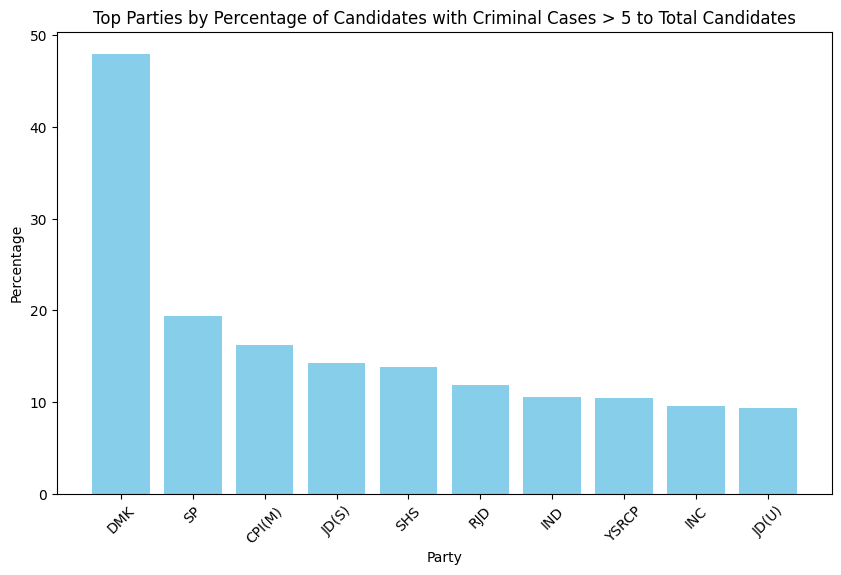

In [60]:
party_counts = {}
total_counts = {}

for index, row in df.iterrows():
    party = row['Party']
    if row['Criminal Case'] > 5:
        if party in party_counts:
            party_counts[party] += 1
        else:
            party_counts[party] = 1
    if party in total_counts:
        total_counts[party] += 1
    else:
        total_counts[party] = 1

ratio = {}
for party, count in party_counts.items():
    ratio[party] = (count / total_counts[party])*100

sorted_ratio = dict(sorted(ratio.items(), key=lambda x: x[1], reverse=True)[:10])
plt.figure(figsize=(10, 6))
plt.bar(sorted_ratio.keys(), sorted_ratio.values(), color='skyblue')
plt.title('Top Parties by Percentage of Candidates with Criminal Cases > 5 to Total Candidates')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.savefig('first.png')

In [195]:
DF = df.copy()
df['Wealth'] = df['Total Assets'] - df['Liabilities']
df['Wealth'].skew()

18.701978647563266

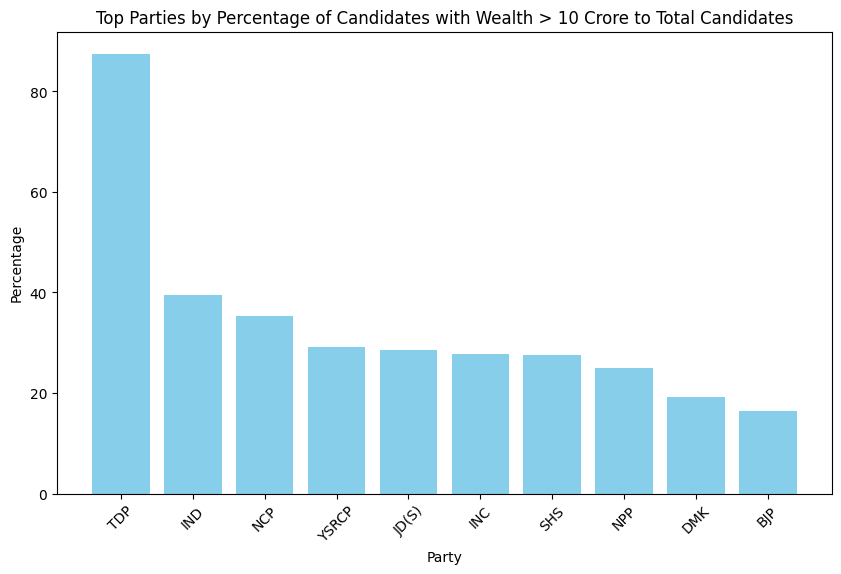

In [24]:
party_counts = {}
total_counts = {}

for index, row in df.iterrows():
    party = row['Party']
    if row['Wealth'] > 1000:
        if party in party_counts:
            party_counts[party] += 1
        else:
            party_counts[party] = 1
    if party in total_counts:
        total_counts[party] += 1
    else:
        total_counts[party] = 1

ratio = {}
for party, count in party_counts.items():
    ratio[party] = (count / total_counts[party])*100

sorted_ratio = dict(sorted(ratio.items(), key=lambda x: x[1], reverse=True)[:10])
plt.figure(figsize=(10, 6))
plt.bar(sorted_ratio.keys(), sorted_ratio.values(), color='skyblue')
plt.title('Top Parties by Percentage of Candidates with Wealth > 10 Crore to Total Candidates')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.savefig('second.png')


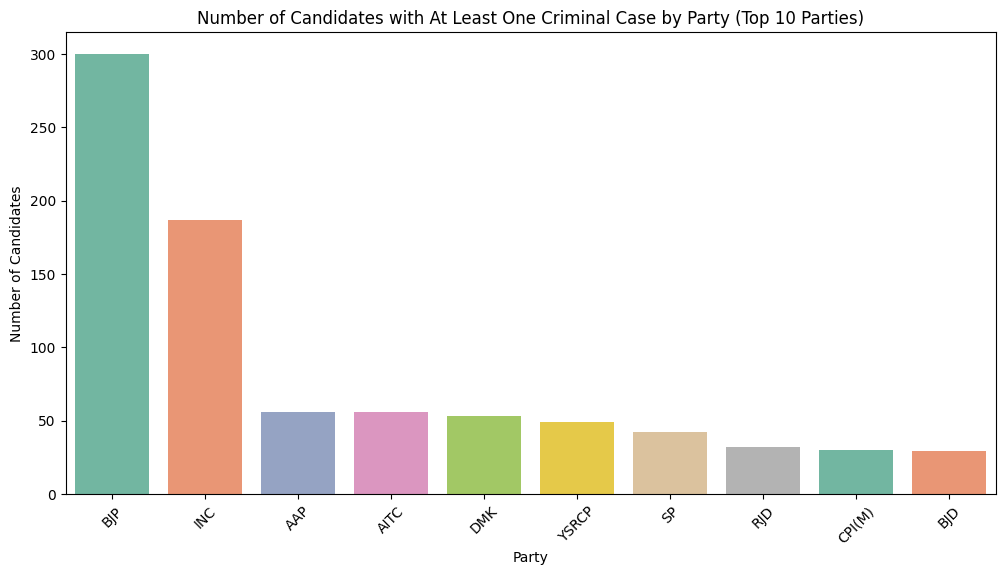

In [25]:
criminal_cases_df = df[df['Criminal Case'] >= 1]
top_10_parties = criminal_cases_df['Party'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.countplot(data=criminal_cases_df, x='Party', order=top_10_parties.index, palette='Set2')
plt.title('Number of Candidates with At Least One Criminal Case by Party (Top 10 Parties)')
plt.xlabel('Party')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.savefig('criminal_bg.png')


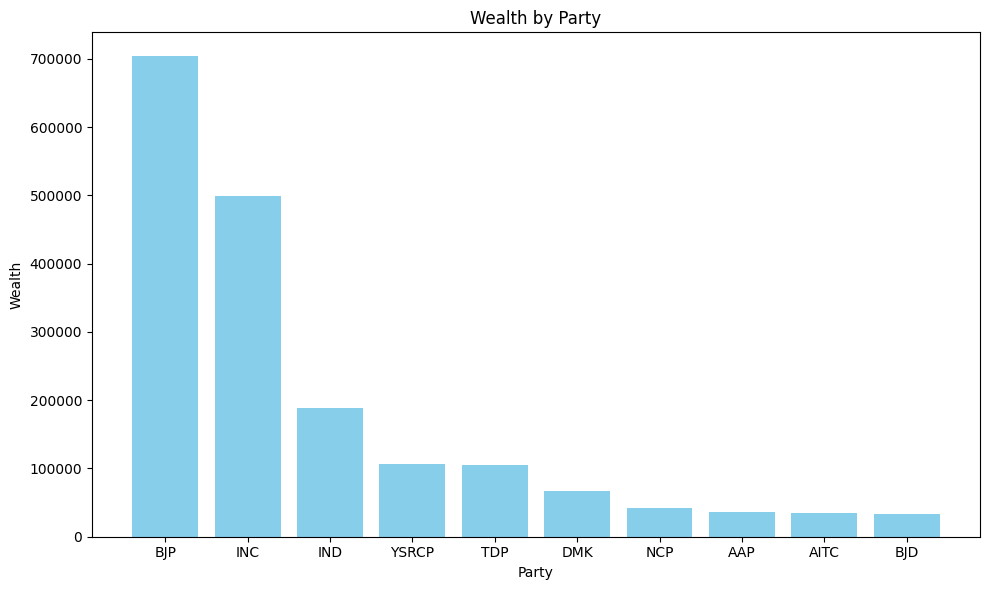

In [26]:
party_assets = df.groupby('Party')['Wealth'].sum().reset_index()
party_assets_sorted = (party_assets.sort_values(by='Wealth', ascending=False))[:10]
plt.figure(figsize=(10, 6))
plt.bar(party_assets_sorted['Party'], party_assets_sorted['Wealth'], color='skyblue')
plt.xlabel('Party')
plt.ylabel('Wealth')
plt.title('Wealth by Party')
plt.tight_layout()
plt.savefig('wealth.png')

In [27]:
df.head()

,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,Wealth
0,ANNA NAGAR,DMK,4,21100.0,200.0,TAMIL NADU,8th Pass,20900.0
1,KARERA (SC),BJP,0,100.0,0.0,MADHYA PRADESH,12th Pass,100.0
2,MADIKERI,INC,0,700.0,22.0,KARNATAKA,Post Graduate,678.0
3,BEGUSARAI,BJP,0,900.0,24.0,BIHAR,Post Graduate,876.0
4,BANGAON DAKSHIN (SC),BJP,2,200.0,61.0,WEST BENGAL,8th Pass,139.0


In [204]:
label_encoder = LabelEncoder()
df_encoded = DF.copy()
df_encoded['Constituency ∇'] = label_encoder.fit_transform(df_encoded['Constituency ∇'])
df_encoded['Party'] = label_encoder.fit_transform(df_encoded['Party'])
df_encoded['state'] = label_encoder.fit_transform(df_encoded['state'])

education_levels = [
    'Literate',             # 0
    '5th Pass',             # 1
    '8th Pass',             # 2
    '10th Pass',            # 3
    '12th Pass',            # 4
    'Graduate',             # 5
    'Post Graduate',        # 6
    'Graduate Professional',# 7
    'Doctorate',            # 8
    'Others'                # 9
]

education_mapping = {level: label for label, level in enumerate(education_levels)}
df_encoded['Criminal Case'] = np.log1p(df_encoded['Criminal Case'])
df_encoded['Total Assets'] = np.log1p(df_encoded['Total Assets'])
df_encoded['Liabilities'] = np.log1p(df_encoded['Liabilities'])

df_encoded['Education'] = df_encoded['Education'].map(education_mapping)
df_encoded.head()

,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,Wealth
0,76,7,1.609438,9.957076,5.303305,23,2,20900.0
1,889,4,0.000000,4.615121,0.000000,13,4,100.0
2,1104,8,0.000000,6.552508,3.135494,11,6,678.0
3,247,4,0.000000,6.803505,3.218876,3,6,876.0
4,184,4,1.098612,5.303305,4.127134,27,2,139.0


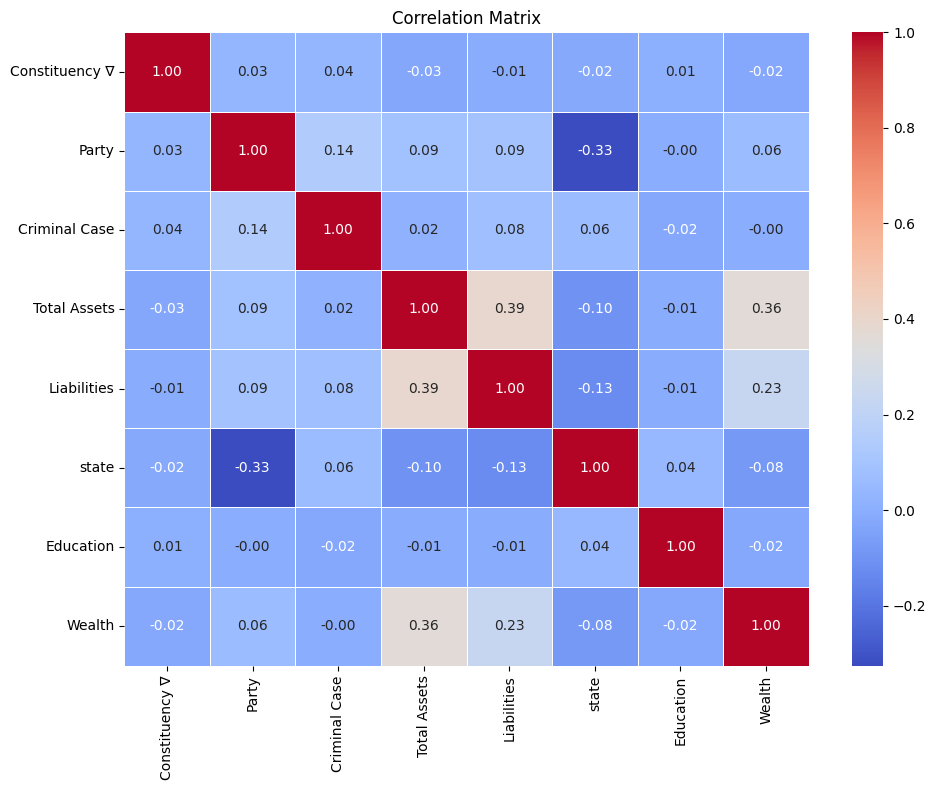

In [205]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.tight_layout()

In [206]:
df_encoded['Wealth'] = df_encoded['Total Assets'] - df_encoded['Liabilities']

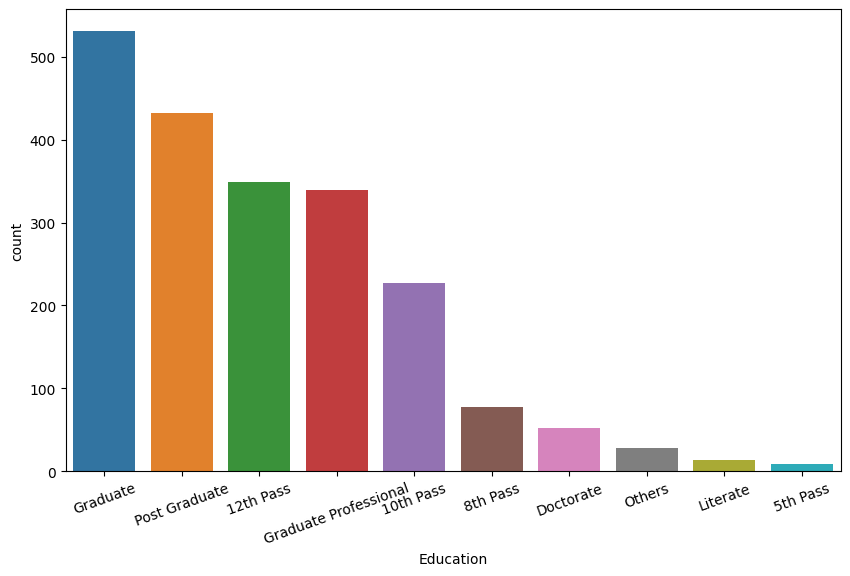

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Education', order=df['Education'].value_counts().index)
plt.xticks(rotation=20)
plt.savefig('count_Education.png')

In [207]:
X = df_encoded.drop(columns=['Education'])
y = df_encoded['Education']

Principal Components and Corresponding Column Names:
PC1: Constituency ∇
PC2: Party
PC3: Criminal Case
PC4: Total Assets
PC5: Liabilities
PC6: state


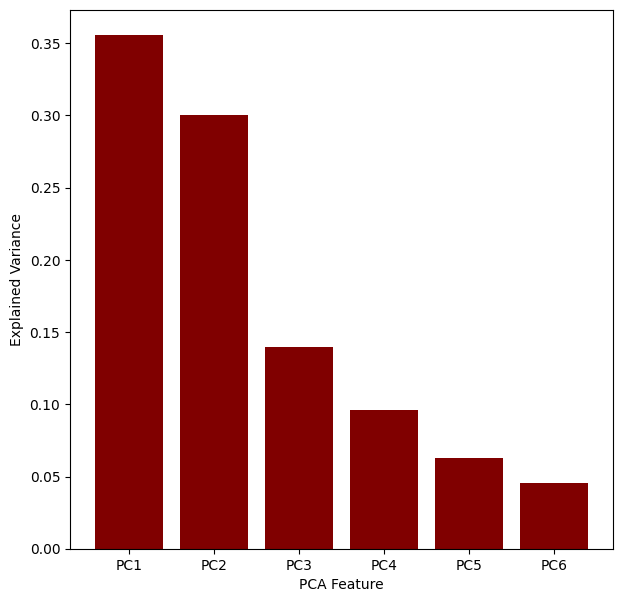

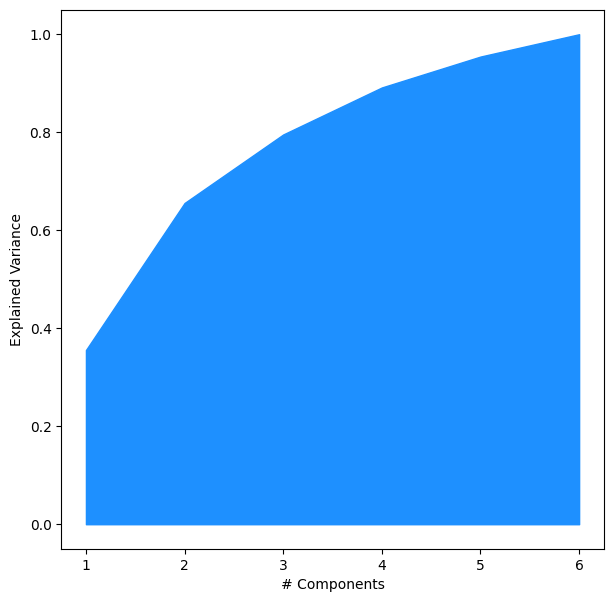

In [209]:
XT = RobustScaler().fit_transform(X)
pca = PCA(n_components=0.99)
XT = pca.fit_transform(XT)
component_names = [f"PC{i+1}" for i in range(pca.n_components_)]
column_names = X.columns

fig = plt.figure(figsize=(7, 7))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, color="maroon")
plt.xlabel("PCA Feature")
plt.ylabel("Explained Variance")
plt.xticks(range(pca.n_components_), component_names)  
plt.savefig('PCA1.png')

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(7, 7))
plt.fill_between(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul, color="dodgerblue")
plt.xlabel("# Components")
plt.ylabel("Explained Variance")
plt.savefig('PCA2.png')
print("Principal Components and Corresponding Column Names:")
for i, (pc_name, col_name) in enumerate(zip(component_names, column_names)):
    print(f"{pc_name}: {col_name}")


In [210]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [214]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [300, 400, 600],  # Number of trees in the forest
    'max_depth': [10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 3, 5],   # Minimum number of samples required to split a node
    'min_samples_leaf': [ 2, 5, 7]      # Minimum number of samples required at each leaf node
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 600}


In [215]:
model = RandomForestClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# reverse_education_mapping = {label: level for level, label in education_mapping.items()}
# # Map the integer labels back to their corresponding education levels
# y_pred = np.vectorize(reverse_education_mapping.get)(y_pred)
# df_predictions = pd.DataFrame({'ID': range(len(y_pred)), 'Education': y_pred})
# df_predictions.head(10)

In [216]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1 Micro Score:", f1_micro)
print("F1 Weighted Score:", f1_weighted)
print("Accuracy:", accuracy)

F1 Micro Score: 0.29449838187702265
F1 Weighted Score: 0.22921891273960926
Accuracy: 0.29449838187702265


In [217]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
n_folds = 5  
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())

Cross-validation scores: [0.24029126 0.23058252 0.24271845 0.29126214 0.27250608]
Mean CV score: 0.25547209033141993
Standard deviation of CV scores: 0.02273186192101156
